# Regression Tree Tutorial  
In this notebook, we'll train and evaluate a RegressionTree model on a sample dataset

We'll start by loading a dataset, such as the infamous iris dataset, from `sklearn.datasets`.

In [70]:
%load_ext autoreload 
%autoreload 2

import numpy as np
import pandas as pd
import sklearn.datasets

def read_dataset(dataset_loader):
    dataset = dataset_loader()
    x = pd.DataFrame(dataset.data,columns=dataset.feature_names)
    y=dataset.target.reshape(-1,1)
    return x,y

dataset_name="diabetes"
dataset_loader = sklearn.datasets.load_diabetes
x,y = read_dataset(dataset_loader)
x.describe(include='all')  


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01


# Model definition
To define our model, we must first create a `TreeTrainer` object. This object will actually take care of the training process for the `Tree` when we call `predict`. The `TreeTrainer` requires some configuration: a `GlobalError` object that can evaluate columns on each split, and a `PruneCriteria` to know then to stop growing the tree.

In this case, we are using the `MixedGlobalError`, with different column splitters for nominal and numeric attributes. In the case of the numeric columns, the `DiscretizingNumericColumnSplitter` with the `OptimizingDiscretizationStrategy` will look for the best binary discretization of each numeric attribute on each split.

Additionally, the `MixedGlobalError` uses an `DeviationMetric` error to evaluate the predictions of the tree; this can be replaced with a custom error metric.

In [ ]:
from sklearnmodels import tree

def get_model():
    # select best discretization for numeric columns, using at most `max_evals` measure evaluations
    numeric_discretization_strategy = tree.OptimizingDiscretizationStrategy(max_evals=30)
    column_errors = {
        "number":tree.DiscretizingNumericColumnSplitter(numeric_discretization_strategy),
        "object":tree.NominalColumnSplitter(),
        "bool":tree.NominalColumnSplitter()
        }
    global_error = tree.MixedGlobalError(column_errors,tree.DeviationMetric())
    prune_criteria = tree.PruneCriteria(max_height=5,min_samples_leaf=20,min_error_improvement=0.01)
    trainer = tree.BaseTreeTrainer(global_error,prune_criteria)
    model = tree.SKLearnRegressionTree(trainer)
    return model


# Training and evaluation

To make this short, we'll both train and evaluate on the train set using the typical `fit` and `predict` methods. This is no different than with any other `scikit-learn` models.

In [132]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

model = get_model()
model.fit(x,y)
y_pred = model.predict(x)
print(f"Dataset {dataset_name:40} mae: {mean_absolute_error(y,y_pred)} mse: {mean_squared_error(y,y_pred)}")


Dataset diabetes                                 mae: 43.20932806209266 mse: 2894.018367866068


# Visualization
Finally, we'll want to visualize our trained tree. We have to choices: a plain text pretty printing of the tree (`Tree.pretty_print()`), or a full blown `graphviz` graph (`tree.export_dot(...)`).

In both cases, well have to grab the `tree` property from our `model`, that holds the actual tree.

In [133]:
print(model.tree.pretty_print())

root
|   🪵s5 <= -0.004222 => 
|   |   🪵bmi <= 0.004572 => 
|   |   |   🪵s3 <= 0.01919 => 
|   |   |   |   🪵s1 <= 0.04934 => 🍁([106.14285714],n=84)
|   |   |   🪵s3 > 0.01919 => 
|   |   |   |   🪵sex <= -0.04464 => 🍁([88.44444444],n=63)
|   |   |   |   🪵sex > -0.04464 => 🍁([68.55],n=20)
|   |   🪵bmi > 0.004572 => 
|   |   |   🪵age > -0.08543 => 
|   |   |   |   🪵bp <= 0.008101 => 🍁([130.39285714],n=28)
|   🪵s5 > -0.004222 => 
|   |   🪵bmi <= 0.01751 => 
|   |   |   🪵bmi <= -0.02237 => 
|   |   |   |   🪵s1 > -0.05386 => 🍁([128.33333333],n=36)
|   |   |   🪵bmi > -0.02237 => 
|   |   |   |   🪵s6 <= 0.09419 => 🍁([175.17948718],n=78)
|   |   🪵bmi > 0.01751 => 
|   |   |   🪵bp <= 0.02187 => 
|   |   |   |   🪵s6 <= 0.02377 => 🍁([164.59090909],n=22)
|   |   |   |   🪵s6 > 0.02377 => 🍁([231.56521739],n=23)
|   |   |   🪵bp > 0.02187 => 
|   |   |   |   🪵bmi <= 0.0714 => 🍁([237.28205128],n=39)


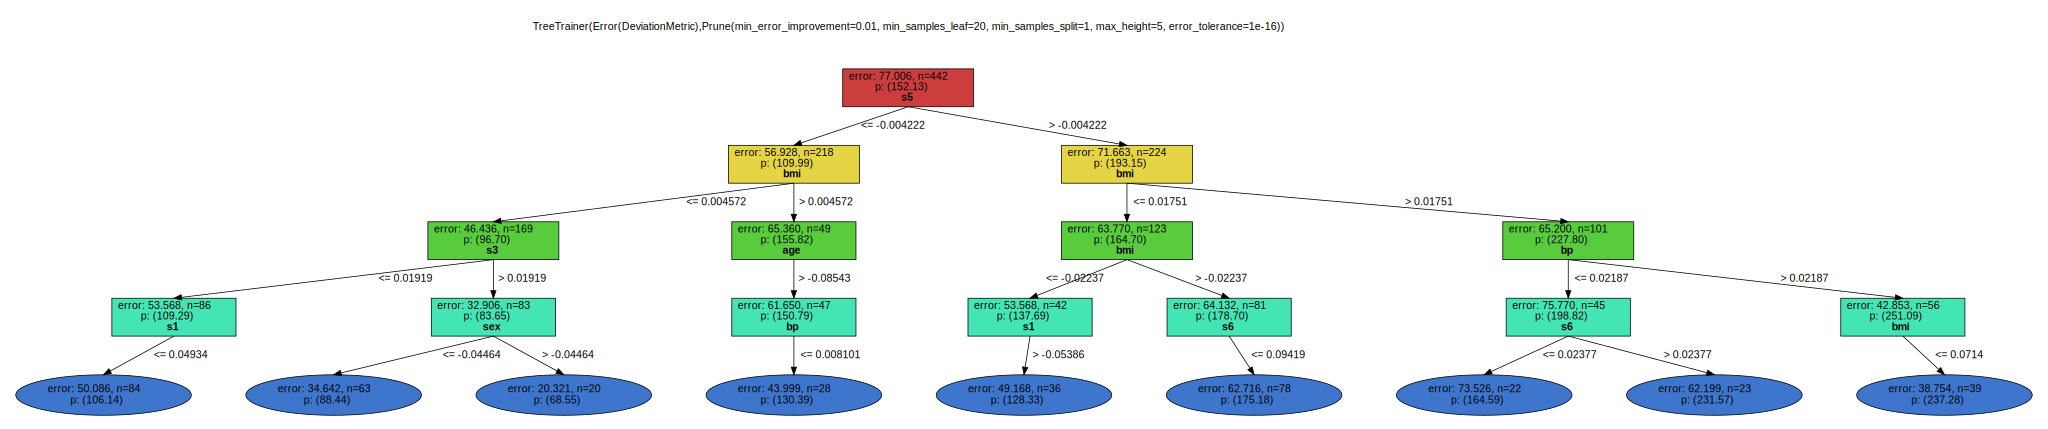

In [134]:
import graphviz 
dot_graph = tree.export_dot(model.tree,title=f"{model.trainer}")
graphviz.Source(dot_graph)
